D:\Publish Paper\ML in Cyber_ash\Plant_disease_detector\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 4/4 [01:08<00:00, 17.12s/it]


Epoch 1/10, Train Loss: 1.5628507435321808, Train Accuracy: 0.8292682926829268, Val Loss: 0.7675343155860901, Val Accuracy: 1.0


100%|██████████| 4/4 [01:03<00:00, 15.94s/it]


Epoch 2/10, Train Loss: 0.6035564988851547, Train Accuracy: 0.991869918699187, Val Loss: 0.39710599184036255, Val Accuracy: 1.0


100%|██████████| 4/4 [00:57<00:00, 14.41s/it]


Epoch 3/10, Train Loss: 0.36925069987773895, Train Accuracy: 0.991869918699187, Val Loss: 0.28623875975608826, Val Accuracy: 1.0


100%|██████████| 4/4 [00:57<00:00, 14.49s/it]


Epoch 4/10, Train Loss: 0.2810766324400902, Train Accuracy: 0.991869918699187, Val Loss: 0.23646137118339539, Val Accuracy: 1.0


100%|██████████| 4/4 [00:57<00:00, 14.37s/it]


Epoch 5/10, Train Loss: 0.23963115364313126, Train Accuracy: 0.991869918699187, Val Loss: 0.20640508830547333, Val Accuracy: 1.0


100%|██████████| 4/4 [00:58<00:00, 14.56s/it]


Epoch 6/10, Train Loss: 0.21163107454776764, Train Accuracy: 0.991869918699187, Val Loss: 0.18451280891895294, Val Accuracy: 1.0


100%|██████████| 4/4 [00:58<00:00, 14.60s/it]


Epoch 7/10, Train Loss: 0.19077694416046143, Train Accuracy: 0.991869918699187, Val Loss: 0.16725440323352814, Val Accuracy: 1.0


100%|██████████| 4/4 [00:58<00:00, 14.51s/it]


Epoch 8/10, Train Loss: 0.1758992224931717, Train Accuracy: 0.991869918699187, Val Loss: 0.15327878296375275, Val Accuracy: 1.0


100%|██████████| 4/4 [00:57<00:00, 14.28s/it]


Epoch 9/10, Train Loss: 0.15985910966992378, Train Accuracy: 1.0, Val Loss: 0.14155863225460052, Val Accuracy: 1.0


100%|██████████| 4/4 [00:58<00:00, 14.54s/it]


Epoch 10/10, Train Loss: 0.1478862464427948, Train Accuracy: 1.0, Val Loss: 0.13124988973140717, Val Accuracy: 1.0
Validation Loss: 0.13124988973140717, Validation Accuracy: 1.0


D:\Publish Paper\ML in Cyber_ash\Plant_disease_detector\.venv\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


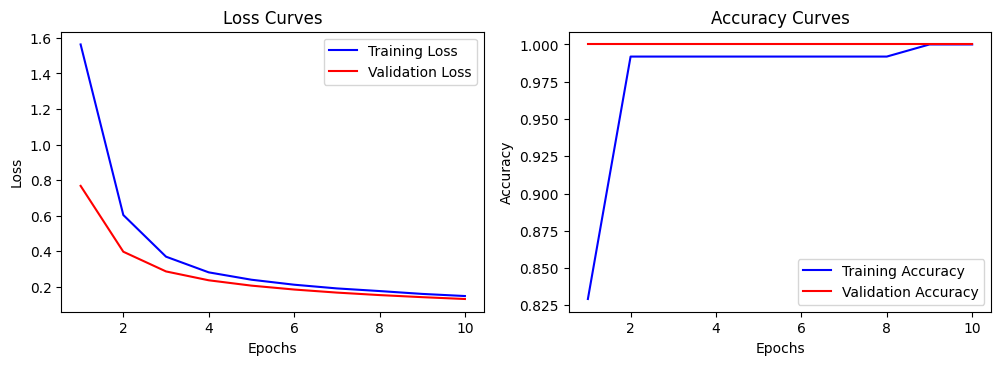

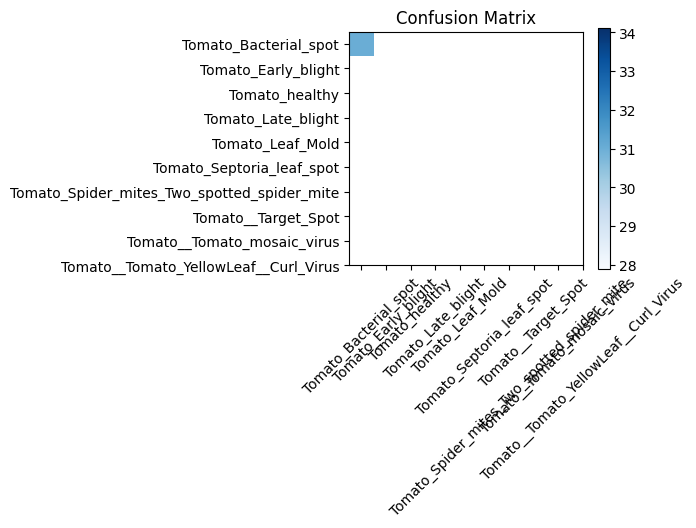

In [1]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from transformers import ViTForImageClassification, ViTFeatureExtractor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Ensure we use a GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class TomatoLeafDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_data(data_dir):
    classes = os.listdir(data_dir)
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
    
    image_paths = []
    labels = []

    for cls_name in classes:
        cls_dir = os.path.join(data_dir, cls_name)
        for root, _, files in os.walk(cls_dir):
            for file in files:
                if file.endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(root, file))
                    labels.append(class_to_idx[cls_name])
    
    return image_paths, labels, class_to_idx

data_dir = 'D:\\Publish Paper\\Dataset plant\\PlantVillage\\train'
image_paths, labels, class_to_idx = load_data(data_dir)

# Split the dataset into training and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = TomatoLeafDataset(train_paths, train_labels, transform=transform)
val_dataset = TomatoLeafDataset(val_paths, val_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
num_classes = len(class_to_idx)

# Load pre-trained ViT model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=num_classes)
model = model.to(device)

from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

optimizer = AdamW(model.parameters(), lr=1e-4)
criterion = CrossEntropyLoss()

def train(model, train_loader, val_loader, epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss /= len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy = evaluate(model, val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}')

    return train_losses, val_losses, train_accuracies, val_accuracies

def evaluate(model, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    return val_loss, val_accuracy

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, val_loader, epochs=10)

# Plot training and validation loss and accuracy graphs
epochs = range(1, len(train_losses)+1)

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

# Evaluate the model on the validation set
val_loss, val_accuracy = evaluate(model, val_loader)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# Compute and plot the confusion matrix
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 3)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
classes = list(class_to_idx.keys())
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.tight_layout()
plt.show()